In [1]:
import sys
my_path = ['/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '/usr/local/lib64/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages', '/usr/lib/python3.6/site-packages']
sys.path = sys.path + my_path

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
from keras import backend as K
from keras.utils.vis_utils import plot_model

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
K.set_image_data_format('channels_first')
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [5]:
def cosine_similarity(vec1, vec2):
    return np.sum(vec1*vec2)/(np.sqrt(np.sum(np.square(vec1))) * np.sqrt(np.sum(np.square(vec2))) )
    
def manhatten_distance(vec1, vec2):
    return np.sqrt(np.sum(np.linalg.norm(np.square(vec1-vec2))))

In [6]:
#FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [7]:
database = {}
person = ["charlie", "adam", "tom", "vimal"]
for obj in person:
    img = cv2.imread("photos/"+obj+".jpg")
    img, _ = face_extract(img)
    database[obj] = img_to_encoding(img, FRmodel, is_cropped=False)

In [8]:
def recognition(image, model=FRmodel, data=database, metric="cosine_similarity", is_cropped=False):
    encoding = img_to_encoding(image, model, is_cropped)
        
    dist = -1
    identity = ""
    for k in data:
        if metric == "cosine_similarity":
            temp = cosine_similarity(encoding, data[k])
        elif metric == "manhatten_distance":
            temp = manhatten_distance(encoding, data[k])
            
        if  temp > dist:
            dist = temp
            identity = k
    return identity,dist*100

In [9]:
def predict(data=database, model=FRmodel):
    cap = cv2.VideoCapture(0)
    count, label, confidence = 0, 0, 0
    while True:
        ret, img = cap.read()
        if ret == True:
            face_img, coordinate = face_extract(img)
            if coordinate is not None:
                [x, y, w, h] = coordinate
                cv2.rectangle(img, (x,y), (y+w, x+h), (0,255,0), 2)
                if count == 0:
                    identity, distance = recognition(face_img, is_cropped=False)
                    cv2.putText(img, "Label: "+str(identity), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
                    cv2.putText(img, "Confidence: "+str(distance), (50,80), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
                
                count = count%80
            cv2.imshow("Window", img)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    cv2.destroyAllWindows()
    cap.release()

In [10]:
predict()

In [11]:
print(FRmodel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
plot_model(FRmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
a = cv2.imread("photos/vimal.jpg")
a, _ = face_extract(a)

error: OpenCV(3.4.2) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<1,-1,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


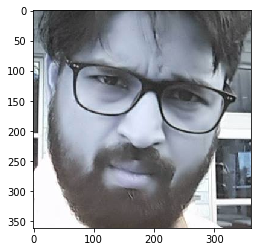

In [17]:
plt.imshow(a)

In [19]:
a = cv2.imread("photos/test4.jpg")
a, _ = face_extract(a)

In [20]:
recognition(a)

('vimal', 79.52937483787537)

In [ ]:
plt.imshow(a)